In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchvision import transforms as trn
import torch.nn.functional as F

import numpy as np

import math
from tqdm import tqdm

RANDOM_SEED = 12345
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [34]:

# Q1: Implementing a Warmup neural network
class WarmupNN(nn.Module):
    def __init__(self):
        super(WarmupNN, self).__init__()

        # simple feedforward network
        self.h1 = nn.Linear(28 * 28, 128)  # 28*28 img dim
        self.h2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)


    def forward(self, x):

        # forward pass of network
        x = torch.flatten(x, 1)
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.out(x)

        return x


def get_accuracy_and_avg_loss(model, data_loader, device):
    criterion = nn.CrossEntropyLoss() # loss func

    # set model to eval test data
    model.eval()

    # Define variables to compute the average batch loss + accuracy for the test dataset
    batch_size = 256
    tot_num_batches = len(data_loader)
    tot_data = tot_num_batches * batch_size
    tot_batch_loss = 0
    tot_correct = 0

    # Iterate over the loader
    for inputs, labels in tqdm(data_loader):

        # Shift to the gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # test data
        torch.no_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        pred_labels = output.max(1).indices

        # update the accumulator variables
        tot_batch_loss += loss
        correct = (pred_labels == labels).float().sum()
        tot_correct += correct

    # Compute the average batch loss + accuracy for the test dataset
    avg_batch_loss = tot_batch_loss / tot_num_batches
    avg_batch_acc = tot_correct / tot_data

    return(avg_batch_acc, avg_batch_loss)



if __name__ == '__main__':

    # Load MNIST dataset
    # make tensor, normalize
    transform = trn.Compose([ trn.ToTensor(),
                              trn.Normalize(mean=[0.5],
                                            std=[0.5]) ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)


    # Create data loaders
    batch_size = 256
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # Assign device for compute
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # simple feedforward nn model
    model = WarmupNN().to(device)

    # loss function and optimizer
    lr_dict = {'lr_1':4*math.e**-3, 'lr_2':4*math.e**-2, 'lr_3':4*math.e**-1}
    curr_lr = 'lr_3'

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_dict[curr_lr], momentum=0.9)

    # Train  model
    num_epochs = 10
    tr_loss_trajectory = []
    tr_acc_trajectory = []
    te_loss_trajectory = []
    te_acc_trajectory = []

    # Loop epochs
    for epoch in range(num_epochs):
        # set model to train
        model.train()

        # Define variables, compute avg batch loss + accuracy for training
        tot_num_batches = len(train_loader)
        tot_data = tot_num_batches * batch_size
        tot_batch_loss = 0
        tot_correct = 0

        # Iterate over data loader
        for inputs, labels in tqdm(train_loader):

            # move to gpu
            inputs, labels = inputs.to(device), labels.to(device)

            # training logic
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            pred_labels = output.max(1).indices


            # update accumulator vars
            tot_batch_loss += loss
            correct = (pred_labels == labels).float().sum()
            tot_correct += correct

        # Compute avg batch loss + accuracy for train dataset
        avg_batch_loss = tot_batch_loss / tot_num_batches
        avg_batch_acc = tot_correct / tot_data
        print(f'Epoch {epoch+1} Loss: {avg_batch_loss} Acc: {avg_batch_acc}')

        # Compute avg batch loss + accuracy for test dataset
        avg_te_acc, avg_te_batch_loss = get_accuracy_and_avg_loss(model, test_loader, device)
        print(f'Epoch {epoch+1} Test Loss: {avg_te_batch_loss} Acc: {avg_te_acc}')

        # add trajectories to lst
        tr_loss_trajectory.append(float(avg_batch_loss))
        tr_acc_trajectory.append(float(avg_batch_acc))
        te_loss_trajectory.append(float(avg_te_batch_loss))
        te_acc_trajectory.append(float(avg_te_acc))

    # Save trajectories to npy
    np.save(f'train_loss_{curr_lr}.npy', np.array(tr_loss_trajectory))
    np.save(f'train_acc_{curr_lr}.npy', np.array(tr_acc_trajectory))
    np.save(f'test_loss_{curr_lr}.npy', np.array(te_loss_trajectory))
    np.save(f'test_acc_{curr_lr}.npy', np.array(te_acc_trajectory))


100%|██████████| 235/235 [00:16<00:00, 14.32it/s]


Epoch 1 Loss: 324.87213134765625 Acc: 0.10410571843385696


100%|██████████| 40/40 [00:02<00:00, 16.43it/s]


Epoch 1 Test Loss: 2.321493625640869 Acc: 0.0986328125


100%|██████████| 235/235 [00:17<00:00, 13.35it/s]


Epoch 2 Loss: 2.315185070037842 Acc: 0.09915225952863693


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


Epoch 2 Test Loss: 2.317229986190796 Acc: 0.0986328125


100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Epoch 3 Loss: 2.3131957054138184 Acc: 0.10274267941713333


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 3 Test Loss: 2.3277597427368164 Acc: 0.11083984375


100%|██████████| 235/235 [00:16<00:00, 14.02it/s]


Epoch 4 Loss: 2.3138394355773926 Acc: 0.10069813579320908


100%|██████████| 40/40 [00:02<00:00, 16.59it/s]


Epoch 4 Test Loss: 2.306992292404175 Acc: 0.09589844197034836


100%|██████████| 235/235 [00:16<00:00, 14.58it/s]


Epoch 5 Loss: 2.3161191940307617 Acc: 0.10312499850988388


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 5 Test Loss: 2.312720775604248 Acc: 0.08710937947034836


100%|██████████| 235/235 [00:15<00:00, 15.01it/s]


Epoch 6 Loss: 2.314664125442505 Acc: 0.10023271292448044


100%|██████████| 40/40 [00:02<00:00, 14.43it/s]


Epoch 6 Test Loss: 2.3048503398895264 Acc: 0.11083984375


100%|██████████| 235/235 [00:18<00:00, 12.98it/s]


Epoch 7 Loss: 2.3126139640808105 Acc: 0.10458776354789734


100%|██████████| 40/40 [00:02<00:00, 15.68it/s]


Epoch 7 Test Loss: 2.3258585929870605 Acc: 0.10039062798023224


100%|██████████| 235/235 [00:18<00:00, 12.96it/s]


Epoch 8 Loss: 2.3148794174194336 Acc: 0.10197805613279343


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 8 Test Loss: 2.305967092514038 Acc: 0.11083984375


100%|██████████| 235/235 [00:15<00:00, 15.04it/s]


Epoch 9 Loss: 2.3159618377685547 Acc: 0.10360704362392426


100%|██████████| 40/40 [00:02<00:00, 16.05it/s]


Epoch 9 Test Loss: 2.3129851818084717 Acc: 0.09511718899011612


100%|██████████| 235/235 [00:15<00:00, 14.85it/s]


Epoch 10 Loss: 2.314082384109497 Acc: 0.10477060824632645


100%|██████████| 40/40 [00:02<00:00, 15.12it/s]

Epoch 10 Test Loss: 2.3133208751678467 Acc: 0.09853515774011612


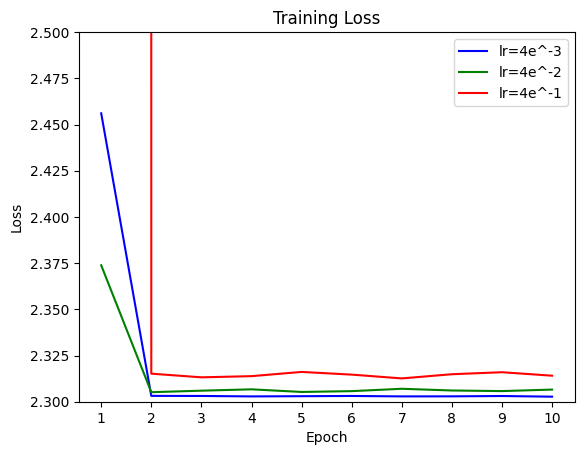

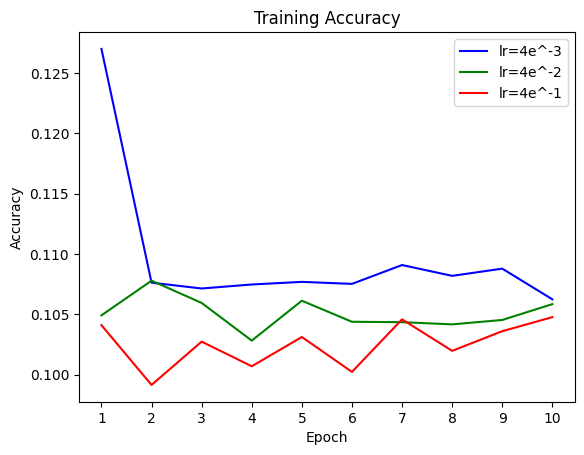

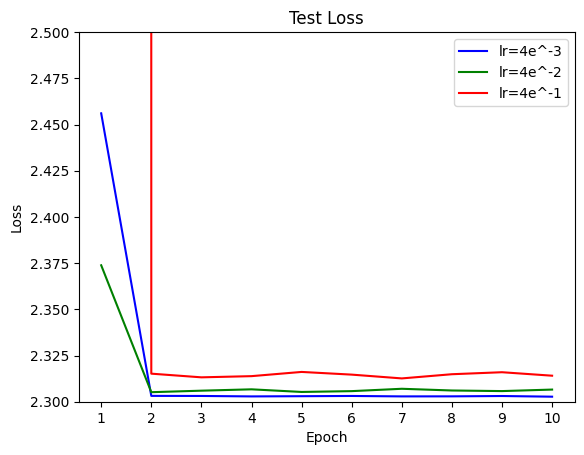

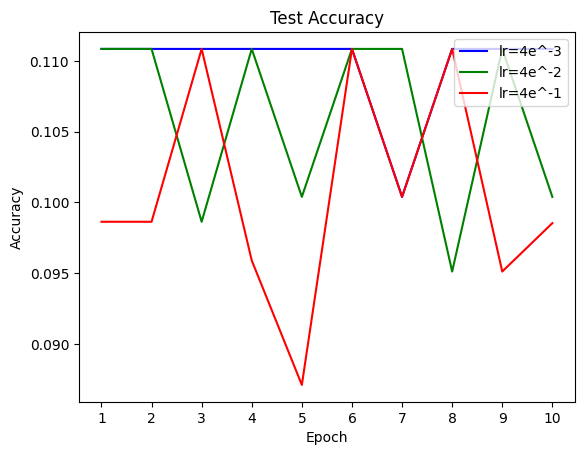

In [72]:
import matplotlib.pyplot as plt

#### TRAIN
# plot loss - 3 alphas
tr_loss1 = np.load('train_loss_lr_1.npy')
tr_loss2 = np.load('train_loss_lr_2.npy')
tr_loss3 = np.load('train_loss_lr_3.npy')

plt.plot(np.arange(1, len(tr_loss1)+1), tr_loss1, c='b', label='lr=4e^-3')
plt.plot(np.arange(1, len(tr_loss1)+1), tr_loss2, c='g', label='lr=4e^-2')
plt.plot(np.arange(1, len(tr_loss1)+1), tr_loss3, c='r', label='lr=4e^-1')
plt.xticks(np.arange(1, len(tr_loss1)+1))
plt.ylim(2.3, 2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.title('Training Loss')
plt.savefig('train_loss_all_lr.png')
plt.show()


# plot acc - 3 alphas
tr_acc1 = np.load('train_acc_lr_1.npy')
tr_acc2 = np.load('train_acc_lr_2.npy')
tr_acc3 = np.load('train_acc_lr_3.npy')

plt.plot(np.arange(1, len(tr_loss1)+1), tr_acc1, c='b', label='lr=4e^-3')
plt.plot(np.arange(1, len(tr_loss1)+1), tr_acc2, c='g', label='lr=4e^-2')
plt.plot(np.arange(1, len(tr_loss1)+1), tr_acc3, c='r', label='lr=4e^-1')
plt.xticks(np.arange(1, len(tr_loss1)+1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=1)
plt.title('Training Accuracy')
plt.savefig('train_acc_all_lr.png')
plt.show()


#### TEST
# plot loss - 3 alphas
te_loss1 = np.load('test_loss_lr_1.npy')
te_loss2 = np.load('test_loss_lr_2.npy')
te_loss3 = np.load('test_loss_lr_3.npy')

plt.plot(np.arange(1, len(tr_loss1)+1), tr_loss1, c='b', label='lr=4e^-3')
plt.plot(np.arange(1, len(tr_loss1)+1), tr_loss2, c='g', label='lr=4e^-2')
plt.plot(np.arange(1, len(tr_loss1)+1), tr_loss3, c='r', label='lr=4e^-1')
plt.xticks(np.arange(1, len(tr_loss1)+1))
plt.ylim(2.3, 2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.title('Test Loss')
plt.savefig('test_loss_all_lr.png')
plt.show()

# plot acc - 3 alphas
te_acc1 = np.load('test_acc_lr_1.npy')
te_acc2 = np.load('test_acc_lr_2.npy')
te_acc3 = np.load('test_acc_lr_3.npy')

plt.plot(np.arange(1, len(tr_loss1)+1), te_acc1, c='b', label='lr=4e^-3')
plt.plot(np.arange(1, len(tr_loss1)+1), te_acc2, c='g', label='lr=4e^-2')
plt.plot(np.arange(1, len(tr_loss1)+1), te_acc3, c='r', label='lr=4e^-1')
plt.xticks(np.arange(1, len(tr_loss1)+1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=1)
plt.title('Test Accuracy')
plt.savefig('test_acc_all_lr.png')
plt.show()